# Relation Extraction

## Set variables

In [1]:
logdir = './logs/BERT' # for tensorboard
MODEL_PATH = 'bert-base-cased'

batch_size = 16
num_train_epochs = 4

Select specific GPU

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Install and import necessary libraries

In [3]:
# ! pip install transformers
# ! pip install pandas
# ! pip install scikit-learn
# ! pip install numpy
# ! pip install torch
# ! pip install optuna
# ! pip install -q tb-nightly
# ! pip install tensorboard
# ! pip install tensorflow

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import shutil
import dill

## Dataset Preprocessing


Dataset config file

In [5]:
root_data_dir = "../Datasets/RE/BiodivRE/"

### GAD Loading

Data loading utils

In [6]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  data = data.fillna(method="ffill")
  return data

In [7]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)

/tmp/ipykernel_2697779/2454678900.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


In [8]:
data_train.head(10)

,Label,Sentence
0,0,( species : species ) The @QUALITY$ are based ...
1,1,Almost half of the threatened species assessed...
2,0,"In 18 grazed and 21 improved fallows , we esti..."
3,0,BEF research plot where the abundance of @ORGA...
4,0,Indicators : Access to clean fuels and technol...
5,0,We demonstrate that I. noli- tangere and I. te...
6,0,Although its marine biota can be considered re...
7,0,We draw on a spatially-replicated dataset on A...
8,0,Ways to quantify @PHENOMENA$ : rainfall amount...
9,0,"In the light of the @QUALITY$ , it is of major..."


In [9]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)

/tmp/ipykernel_2697779/2454678900.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


In [10]:
data_test.head(10)

,Label,Sentence
0,1,( loss_f : average sandloss forest g m-2 -- --...
1,0,"In a grassland biodiversity experiment , we ad..."
2,0,Indicators : Access to clean fuels and technol...
3,1,The cbbL form IA and IC genes associated with ...
4,1,Microbial biomass and diversity increased in m...
5,0,DESCRIPTION Combined @ORGANISM$ Data SUMMARY T...
6,1,"@QUALITY$ ( rare_fg_se ) , dimensionless rare_..."
7,0,Indicators : Access to clean fuels and technol...
8,1,Our results show that existing @ENVIRONMENT$ i...
9,0,Indicators : Access to clean fuels and technol...


In [11]:
data_dev = loadData(csv_file_path='dev.csv', header=None, index_col=None)

/tmp/ipykernel_2697779/2454678900.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


In [12]:
data_dev.head(10)

,Label,Sentence
0,1,We hypothesized that ( i ) the food choice of ...
1,0,Ways to quantify precipitation : rainfall amou...
2,0,Potential areas for @PHENOMENA$ almost double ...
3,1,( CSP14 : BEF research plot where the @QUALITY...
4,1,-- - Crown length is calculated as the total t...
5,0,Spatiotemporal modulation of biodiversity in a...
6,0,Ways to quantify precipitation : rainfall amou...
7,0,( Age : the @QUALITY$ class assigned at the ti...
8,1,This system is an important model for understa...
9,0,Ways to quantify @PHENOMENA$ : rainfall amount...


In [13]:
print(len(data_train), len(data_test), len(data_dev))

3200 400 400


split texts and labels

In [14]:
data_train.columns

Index(['Label', 'Sentence'], dtype='object')

In [15]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [16]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [17]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [18]:
plt.style.use("ggplot")

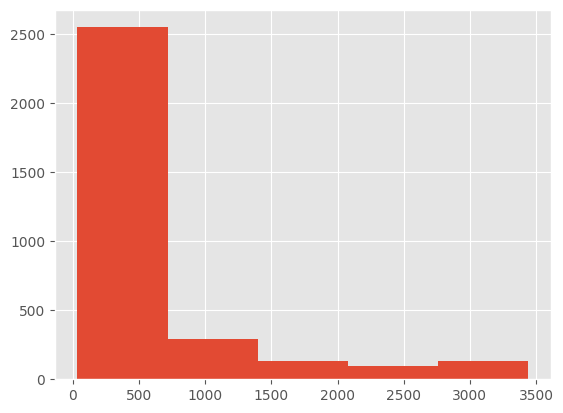

In [19]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [20]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

3442

In [21]:
max([len(s) for s in test_texts])

3436

In [22]:
max([len(s) for s in dev_texts])

3432

## Explicit Truncation

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [24]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True, max_length=128)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)

In [25]:
len(train_encodings[0])

128

### Dataset objects 

Create the dataset objects

In [26]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, dev_labels)
test_dataset = MyDataset(test_encodings, test_labels)

# Hyperparameter Optimization

## Set-up

Instantiating the model

In [28]:
from transformers import AutoModelForSequenceClassification

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

Defining the hyperparameter search space

In [29]:
from optuna import Trial
from typing import Dict, Union

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 6),
    }

Defining the compute_metrics function

In [30]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

Clear model directory if it hasn't been cleared yet.

In [31]:
def delete_dir(directory_path):
    if os.path.exists(directory_path):
        try:
            # Remove the directory
            shutil.rmtree(directory_path)
            print(f"Directory '{directory_path}' removed successfully.")
        except Exception as e:
            print(f"Error removing directory '{directory_path}': {e}")
    else:
        print(f"Directory '{directory_path}' does not exist.")

delete_dir("./results")
delete_dir("./re.model")

Directory './results' does not exist.
Directory './re.model' does not exist.


In [32]:
from transformers import TrainerCallback, TrainerState

class CleanupCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        shutil.rmtree("./results", ignore_errors=True)

Defining the training arguments

In [33]:
from transformers import Trainer, TrainingArguments
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    # gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=logdir,            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    report_to="none"
  )

trainer = Trainer(
    model_init=model_init,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,  
    callbacks=[CleanupCallback()], # EarlyStoppingCallback(early_stopping_patience=3), CleanupCallback()
)

2024-03-14 03:19:23.535435: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 03:19:23.630543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-03-14 03:19:25.269677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Hyperparameter Search

In [34]:
best_run = trainer.hyperparameter_search(hp_space=hp_space, n_trials=30, direction="maximize")

[I 2024-03-14 03:19:33,968] A new study created in memory with name: no-name-08ac1550-51dd-4ced-9fec-e6006d23e4c0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.665800,0.647969,0.660000
2,0.572400,0.566416,0.667500
3,0.559800,0.532448,0.730000
4,0.442500,0.483535,0.765000
5,0.358000,0.521706,0.780000
6,0.361400,0.486394,0.762500


[I 2024-03-14 03:24:04,272] Trial 0 finished with value: 0.7625 and parameters: {'learning_rate': 2.7279193203586207e-05, 'num_train_epochs': 6}. Best is trial 0 with value: 0.7625.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.565400,0.563206,0.700000
2,0.451100,0.485159,0.772500
3,0.444900,0.430219,0.795000
4,0.378800,0.463815,0.792500


[I 2024-03-14 03:27:04,837] Trial 1 finished with value: 0.7925 and parameters: {'learning_rate': 0.0003286986461428229, 'num_train_epochs': 4}. Best is trial 1 with value: 0.7925.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.782700,0.766640,0.342500
2,0.731500,0.725901,0.342500
3,0.687500,0.677249,0.617500
4,0.648300,0.633091,0.660000


[I 2024-03-14 03:30:04,203] Trial 2 finished with value: 0.66 and parameters: {'learning_rate': 1.808263959111454e-06, 'num_train_epochs': 4}. Best is trial 1 with value: 0.7925.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.612600,0.614350,0.657500
2,0.532300,0.535728,0.712500
3,0.511400,0.477239,0.772500
4,0.392800,0.470388,0.770000
5,0.302500,0.551849,0.782500


[I 2024-03-14 03:33:47,791] Trial 3 finished with value: 0.7825 and parameters: {'learning_rate': 5.9321764617948245e-05, 'num_train_epochs': 5}. Best is trial 1 with value: 0.7925.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.662300,0.645147,0.660000
2,0.568400,0.564227,0.665000
3,0.553100,0.533006,0.730000


[I 2024-03-14 03:36:03,737] Trial 4 finished with value: 0.73 and parameters: {'learning_rate': 2.8566390581090952e-05, 'num_train_epochs': 3}. Best is trial 1 with value: 0.7925.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.600100,0.600554,0.657500


[I 2024-03-14 03:36:49,079] Trial 5 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.581600,0.577945,0.657500


[I 2024-03-14 03:37:33,659] Trial 6 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.783400,0.767466,0.342500


[I 2024-03-14 03:38:18,400] Trial 7 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698400,0.676803,0.625000


[I 2024-03-14 03:39:02,848] Trial 8 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.593100,0.590880,0.657500


[I 2024-03-14 03:39:47,493] Trial 9 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.542500,0.532124,0.705000
2,0.505200,0.496298,0.740000
3,0.537900,0.544830,0.670000


[I 2024-03-14 03:42:02,615] Trial 10 finished with value: 0.67 and parameters: {'learning_rate': 0.0009675310165114903, 'num_train_epochs': 3}. Best is trial 1 with value: 0.7925.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.537600,0.544847,0.717500
2,0.470400,0.481593,0.790000
3,0.487600,0.487895,0.767500
4,0.437600,0.496096,0.760000
5,0.410000,0.661737,0.737500


[I 2024-03-14 03:45:46,450] Trial 11 finished with value: 0.7375 and parameters: {'learning_rate': 0.0006143952855814128, 'num_train_epochs': 5}. Best is trial 1 with value: 0.7925.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.563900,0.567669,0.665000
2,0.473300,0.456068,0.792500
3,0.459200,0.475182,0.790000
4,0.382400,0.458731,0.795000


[I 2024-03-14 03:48:46,183] Trial 12 finished with value: 0.795 and parameters: {'learning_rate': 0.000243560554535949, 'num_train_epochs': 4}. Best is trial 12 with value: 0.795.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.558600,0.558598,0.695000
2,0.496300,0.495756,0.762500
3,0.431500,0.458255,0.802500
4,0.385600,0.456333,0.795000


[I 2024-03-14 03:51:45,734] Trial 13 finished with value: 0.795 and parameters: {'learning_rate': 0.0002951025854369502, 'num_train_epochs': 4}. Best is trial 12 with value: 0.795.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.557300,0.557391,0.692500
2,0.459300,0.465645,0.785000
3,0.462200,0.481359,0.757500
4,0.386100,0.451118,0.812500


[I 2024-03-14 03:54:45,423] Trial 14 finished with value: 0.8125 and parameters: {'learning_rate': 0.00025979405788260457, 'num_train_epochs': 4}. Best is trial 14 with value: 0.8125.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.737900,0.717568,0.345000


[I 2024-03-14 03:55:30,513] Trial 15 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.571800,0.572628,0.657500


[I 2024-03-14 03:56:14,989] Trial 16 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.538300,0.545882,0.695000
2,0.451300,0.515009,0.745000


[I 2024-03-14 03:57:43,416] Trial 17 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.745000,0.725163,0.342500


[I 2024-03-14 03:58:27,949] Trial 18 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.571600,0.566088,0.657500


[I 2024-03-14 03:59:12,490] Trial 19 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.630200,0.622864,0.657500


[I 2024-03-14 03:59:57,393] Trial 20 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.560000,0.559567,0.692500
2,0.461400,0.449152,0.797500
3,0.427100,0.452948,0.807500
4,0.352600,0.493363,0.800000


[I 2024-03-14 04:02:56,462] Trial 21 finished with value: 0.8 and parameters: {'learning_rate': 0.00028862231130277055, 'num_train_epochs': 4}. Best is trial 14 with value: 0.8125.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.537100,0.523070,0.742500
2,0.470800,0.543285,0.752500


[I 2024-03-14 04:04:25,484] Trial 22 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.573800,0.568216,0.657500


[I 2024-03-14 04:05:10,507] Trial 23 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.546000,0.553051,0.697500
2,0.461300,0.486099,0.757500


[I 2024-03-14 04:06:39,517] Trial 24 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.583300,0.580029,0.657500


[I 2024-03-14 04:07:24,693] Trial 25 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.566700,0.571022,0.657500


[I 2024-03-14 04:08:09,115] Trial 26 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.540200,0.548919,0.712500
2,0.493000,0.478040,0.782500
3,0.450300,0.552972,0.770000
4,0.400300,0.546739,0.762500


[I 2024-03-14 04:11:06,678] Trial 27 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.618100,0.617250,0.657500


[I 2024-03-14 04:11:52,050] Trial 28 pruned. 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.722800,0.701308,0.430000


[I 2024-03-14 04:12:36,667] Trial 29 pruned. 


In [35]:
print(best_run)

BestRun(run_id='14', objective=0.8125, hyperparameters={'learning_rate': 0.00025979405788260457, 'num_train_epochs': 4}, run_summary=None)


# Fine-tuning With Best Hyperparameters

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.args.report_to="tensorboard"
trainer.add_callback(TensorBoardCallback())

In [ ]:
trainer.train()
trainer.evaluate()
trainer.save_model('re.model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.557300,0.557391,0.692500
2,0.459300,0.465645,0.785000
3,0.462200,0.481359,0.757500
4,0.386100,0.451118,0.812500


# Prediction

The use of validation dataset

In [37]:
eval_history = trainer.evaluate()

In [38]:
predictionsOutput = trainer.predict(test_dataset) 

In [39]:
predictionsOutput.predictions.shape

(400, 2)

In [40]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [41]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(400,)

Explore one example of the test dataset (prediction vs. true) lables.

In [42]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

0 ( loss_f : average sandloss forest g m-2 -- -- ) real Deriving kinetic energy from @PHENOMENA$ @QUALITY$ is derived from sand loss out of splashcups .
1 ( loss_f : average sandloss forest g m-2 -- -- ) real Deriving kinetic energy from @PHENOMENA$ @QUALITY$ is derived from sand loss out of splashcups .


# Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [43]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [44]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.805


In [45]:
from sklearn.metrics import precision_recall_fscore_support

In [46]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

(array([0.82608696, 0.75806452]),
 array([0.88372093, 0.66197183]),
 array([0.85393258, 0.70676692]),
 array([258, 142]))

In [47]:
from sklearn.metrics import classification_report

In [48]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       258
           1       0.76      0.66      0.71       142

    accuracy                           0.81       400
   macro avg       0.79      0.77      0.78       400
weighted avg       0.80      0.81      0.80       400



In [49]:
results = classification_report(y_true, y_pred, output_dict=True)
results

{'0': {'precision': 0.8260869565217391,
  'recall': 0.8837209302325582,
  'f1-score': 0.8539325842696629,
  'support': 258.0},
 '1': {'precision': 0.7580645161290323,
  'recall': 0.6619718309859155,
  'f1-score': 0.706766917293233,
  'support': 142.0},
 'accuracy': 0.805,
 'macro avg': {'precision': 0.7920757363253856,
  'recall': 0.7728463806092368,
  'f1-score': 0.780349750781448,
  'support': 400.0},
 'weighted avg': {'precision': 0.8019389901823282,
  'recall': 0.805,
  'f1-score': 0.8016887724930303,
  'support': 400.0}}

### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [50]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

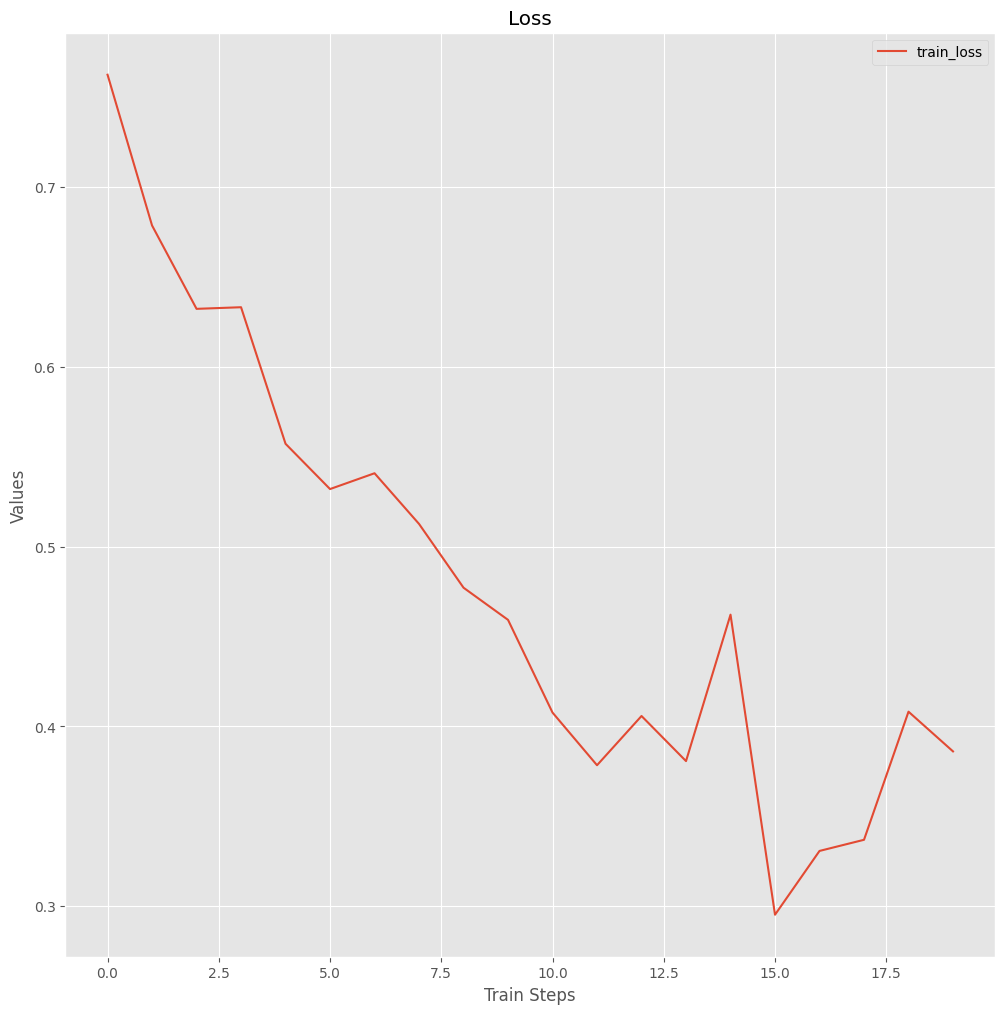

In [51]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with training/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    # loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [52]:
eval_history

{'eval_loss': 0.4511183202266693,
 'eval_accuracy': 0.8125,
 'eval_runtime': 1.6815,
 'eval_samples_per_second': 237.881,
 'eval_steps_per_second': 14.868,
 'epoch': 4.0}